# arXivTM

In [1]:
import os
import re
import copy
import pandas as pd
import numpy as np
import json
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from IPython.display import HTML
import seaborn as sns
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
class topic_modelling():
    def __init__(self):
        self.params = {
            'data_source': None,
            'json_prefix': '',
            'scope': ['title', 'abstract'],
            'language': 'english',
            'remove_stopwords': True,
            'additional_stopwords': set(),
            'stem_words': False,
            'lemmatize_words': True,
            'tfidf': True,
            'bigrams': True,
            'bigram_min': 2,
            'bigram_threshold': 3,
            'trigrams': True,
            'trigram_min': 2,
            'trigram_threshold': 3
        }
        self.data = {}
        
    def set_project_parameters(self, **kwargs):              
        for k, v in kwargs.items():
            if k == 'params':
                assert type(v) is dict, "params need to be passed as dict"
                self.params.update(params)
            else:
                self.params[k] = v
    
    def read_json(self):
        if self.params['data_source'] is None:
            print('Error. You need to set a data source in the params first')
            return
        if self.params['scope'] is None:
            print('Error. You need to set the scope of the data in the params first.')
        
        with open(self.params['data_source']) as infile:
            json_data = json.load(infile)
        data = []
        for k, i in json_data.items():
            identifier = k
            for item_type, item_value in i.items():
                data_value = ''
                prefix = self.params['json_prefix']
                if item_type[len(prefix):] in self.params['scope']:
                    data_value += item_value + ' '
            data.append([identifier, data_value])
        self.data['raw'] = data
 
    def preprocess_text(self, data):
        # Remove line breaks
        data.replace('\n',' ')
        data = re.sub(' +',' ', data)
        
        # Tokenize data
        tokenizer = RegexpTokenizer(r'\w+')
        data = tokenizer.tokenize(data.lower())
        
        # Remove numbers, but not words that contain numbers.
        #data = [token for token in data if not token.isdigit()]

        #if self.params['remove_stopwords']:
        #    stop = set(stopwords.words(self.params['language']))
        #    for i in self.params['additional_stopwords']:
        #        stop.add(i)
        #    data = [token for token in data if not token in stop]

        if self.params['stem_words']:
            stemmer = SnowballStemmer(self.param['language'])
            data = [stemmer.stem(token) for token in data]

        if self.params['lemmatize_words']:
            lemmatizer = WordNetLemmatizer()
            data = [lemmatizer.lemmatize(token) for token in data]
            
        if self.params['bigrams']:
            bigram = self.params['bigram_phraser']
            data = bigram[data]
        
        if self.params['bigrams'] and self.params['trigrams']:
            trigram = self.params['trigram_phraser'] 
            data = trigram[data]
        elif trigrams and not bigrams:
            print('Error. Trigrams requires Bigrams.')
        return data
        
    def preprocess_corpus(self): 
        # Remove line breaks and double spaces
        data = self.data['raw']
        
        data = [[item[0], item[1].replace('\n',' ')] for item in data]
        data = [[item[0], re.sub(' +',' ', item[1])] for item in data]

        # Tokenize data
        tokenizer = RegexpTokenizer(r'\w+')
        data = [[item[0], tokenizer.tokenize(item[1].lower())] for item in data]

        # Remove numbers, but not words that contain numbers.
        data = [[item[0], [token for token in item[1] if not token.isdigit()]] for item in data]

        if self.params['remove_stopwords']:
            stop = set(stopwords.words(self.params['language']))
            for i in self.params['additional_stopwords']:
                stop.add(i)
            data = [[item[0], [token for token in item[1] if not token in stop]] for item in data]

        if self.params['stem_words']:
            stemmer = SnowballStemmer(self.params['language'])
            data = [[item[0], [stemmer.stem(token) for token in item[1]]] for item in data]

        if self.params['lemmatize_words']:
            lemmatizer = WordNetLemmatizer()
            data = [[item[0], [lemmatizer.lemmatize(token) for token in item[1]]] for item in data]

        data = [list(item) for item in list(list(zip(*data)))]
        
        if self.params['bigrams']:
            bi_phrases = Phrases(data[1], min_count=self.params['bigram_min'], 
                                 threshold=self.params['bigram_threshold'])
            bigram = Phraser(bi_phrases)
            data = [data[0], [bigram[d] for d in data[1]]]
            self.params['bigram_phraser'] = bigram
        if self.params['bigrams'] and self.params['trigrams']:
            tri_phrases = Phrases(bigram[data[1]], min_count=self.params['trigram_min'], 
                                  threshold=self.params['trigram_threshold'])
            trigram = Phraser(tri_phrases)
            self.params['trigram_phraser'] = trigram
            data = [data[0], [trigram[d] for d in data[1]]]
        elif trigrams and not bigrams:
            print('Error. Trigrams requires Bigrams.')
        self.data['corpus'] = data
          
    def lda(self, num_topics=10, passes=50):    
        texts = self.data['corpus'][1]
        # create dictionary of terms
        dictionary = corpora.Dictionary(texts)
        print('dictionary created')

        # convert tokenized documents into a document-term matrix
        dtm = [dictionary.doc2bow(text) for text in texts]
        print('doctument-term matrix created')

        if self.params['tfidf']:
            tfidf = models.TfidfModel(dtm)
            dtm = tfidf[dtm]
            print('tf-idf created')

        # generate LDA model
        ldamodel = models.ldamodel.LdaModel(dtm, num_topics=num_topics, id2word=dictionary, passes=passes)
        print('lda-model created')

        if 'lda' not in self.data.keys():
            self.data['lda'] = {}
        
        self.data['lda'][num_topics] = {
            'model': ldamodel,
            'dtm': dtm,
            'dictionary': dictionary
        }
        return ldamodel, dtm, dictionary
    
    def ldavis(self, num_topics):
        if num_topics in self.data['lda'].keys():
            ldamodel = self.data['lda'][num_topics]['model']
            dtm = self.data['lda'][num_topics]['dtm']
            dictionary = self.data['lda'][num_topics]['dictionary']
        
            vis_data = pyLDAvis.gensim.prepare(ldamodel, dtm, dictionary)
            vis = pyLDAvis.display(vis_data)
            return vis
        else:
            print('No model for this number of topics has been generated.')
    
    def get_topics_by_term(self, num_topics=None, num_words=10):
        if num_topics is None:
            print('Error. You need to pass the number of topics.')
            return
        elif num_topics not in self.data['lda'].keys():
            print('No model for this number of topics has been generated.')
            return
        else:
            ldamodel = self.data['lda'][num_topics]['model']
            dictionary = self.data['lda'][num_topics]['dictionary']
        
        
        topical_terms = set()
        for topic in ldamodel.show_topics(num_words=num_words, formatted=False):
            for word in topic[1]:
                topical_terms.add(word[0])
        
        tbt = {}
        for topic in ldamodel.show_topics(num_words=10000, formatted=False):
            tbt[topic[0]] = {}
            for word in topical_terms:
                tbt[topic[0]][word] = 0
            for word in topic[1]:
                if word[0] in topical_terms:
                        tbt[topic[0]][word[0]] = word[1]
            
        self.data['lda'][num_topics]['tbt'] = pd.DataFrame.from_dict(tbt)
        #print(tbt)
        return pd.DataFrame.from_dict(tbt)
        
        '''
        topics_by_doc = {}
        for i in range(len(doc_data[0])):
            tmp_bow = dictionary.doc2bow(doc_data[1][i])
            topics_by_doc[doc_data[0][i]] = {
            'id': doc_data[0][i],
            'abstract': doc_data[1][i],
            'topics': ldamodel.get_document_topics(tmp_bow)
            }
        '''
        
    def tbt_plot(self, style='line', num_topics=None, num_words=10, aspect=3):
        if not num_topics in self.data['lda'].keys():
            print('Error. Not yet...')
            return
        if not 'tbt' in self.data['lda'][num_topics]:
            self.get_topics_by_term(num_topics=num_topics, num_words=num_words)
        if style == 'line':
            viz = sns.relplot(data=self.data['lda'][num_topics]['tbt'], aspect=aspect, 
                              kind='line', dashes=False, markers=True, sort=False) 
            viz.set_xticklabels(rotation=60, ha='right')
        elif style == 'vertical':
            terms = list(self.data['lda'][num_topics]['tbt'][0].keys())
            topics = list(self.data['lda'][num_topics]['tbt'].keys())
            topics_str = [str(x) for x in list(self.data['lda'][num_topics]['tbt'].keys())]
            values = self.data['lda'][num_topics]['tbt']
            
            fig, ax = plt.subplots(1, len(topics), figsize=(18,10), sharey=True)
            palette = plt.get_cmap('Set1')
            num=0
            for i in range(len(topics)):
                num+=1
                ax[i].plot(values[i], terms, marker='', color=palette(num), linewidth=1, alpha=0.7) #, label=column)
                ax[i].fill_betweenx(terms, values[i], color=palette(num), alpha=0.2)
    
    def topics_by_document(self, num_topics=None):
        if num_topics not in self.data['lda'].keys():
            print('Error. Pass...')
            return
        ldamodel = self.data['lda'][num_topics]['model']
        dictionary = self.data['lda'][num_topics]['dictionary']
        results = {}
        for i in range(num_topics):
            results[i] = {}
            for doc in self.data['raw']:
                results[i][doc[0]] = 0
        for doc in self.data['raw']:
            text = self.preprocess_text(doc[1])    
            tmp_bow = dictionary.doc2bow(text)
            tmp_results = ldamodel.get_document_topics(tmp_bow)
            for t in tmp_results:
                results[t[0]][doc[0]] = t[1]
        self.data['lda'][num_topics]['tbd'] = pd.DataFrame.from_dict(results)
        return self.data['lda'][num_topics]['tbd']

## Initialize topic modelling project and set variables 

In [3]:
base_dir = 'data'
data_file = 'arXiv_coprus_topics_transparency.json'

params = {
    'data_source': os.path.join(base_dir, data_file),
    'data_raw': None,
    'json_prefix': 'http://arxiv.org/OAI/arXiv/:',
    'scope': ['title', 'abstract'],
    'language': 'english',
    'remove_stopwords': True,
    'additional_stopwords': set(),
    'stem_words': False,
    'lemmatize_words': True,
    'tfidf': False,
    'bigrams': True,
    'bigram_min': 2,
    'bigram_threshold': 3,
    'trigrams': True,
    'trigram_min': 2,
    'trigram_threshold': 3
}

atm = topic_modelling()
atm.set_project_parameters(params=params)
atm.read_json()
atm.preprocess_corpus()

In [4]:
ldamodel, dtm, dictionary = atm.lda(num_topics=4, passes=200) #, passes=200)

dictionary created
doctument-term matrix created
lda-model created


In [5]:
atm.ldavis(num_topics=4)

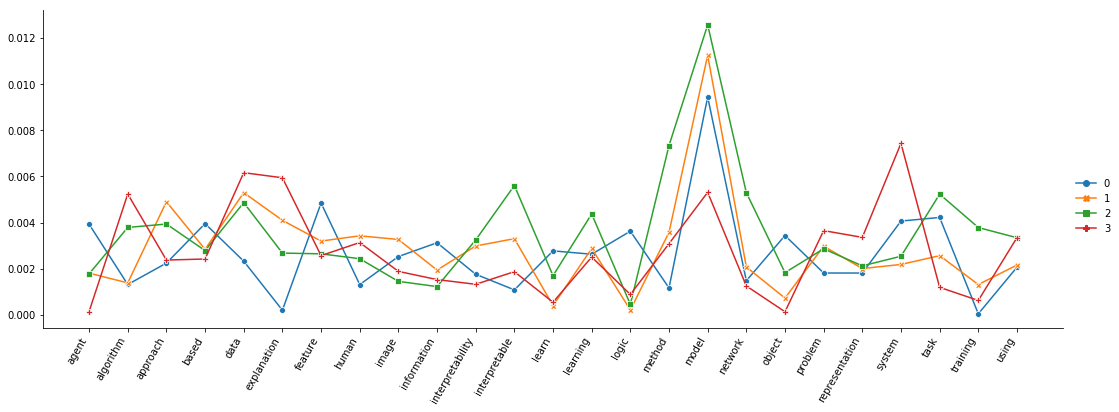

In [6]:
atm.get_topics_by_term(num_topics=4, num_words=10)
atm.tbt_plot(num_topics=4)

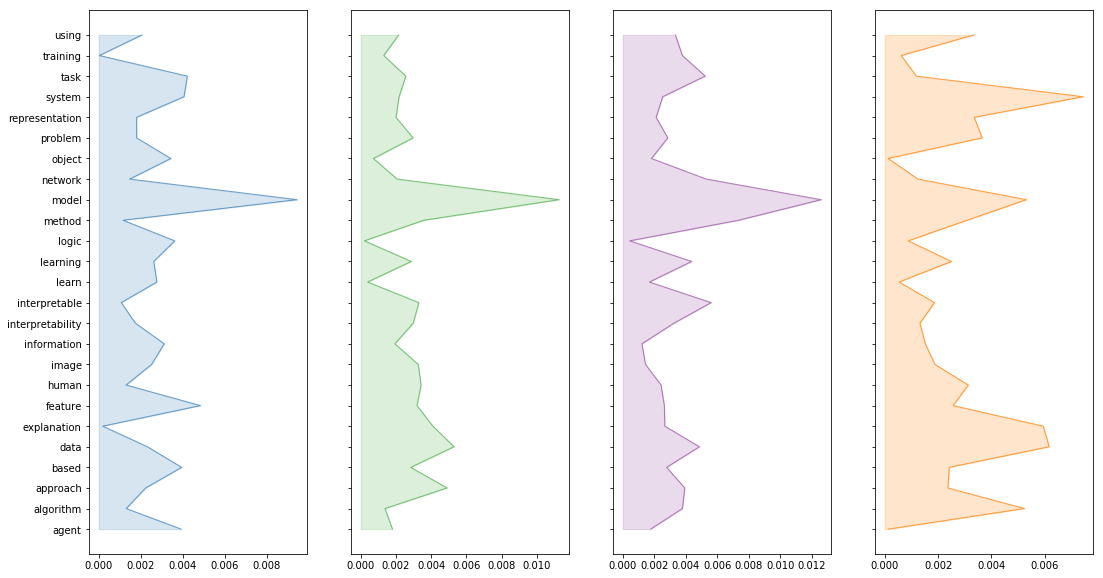

In [7]:
atm.tbt_plot(num_topics=4, style='vertical')

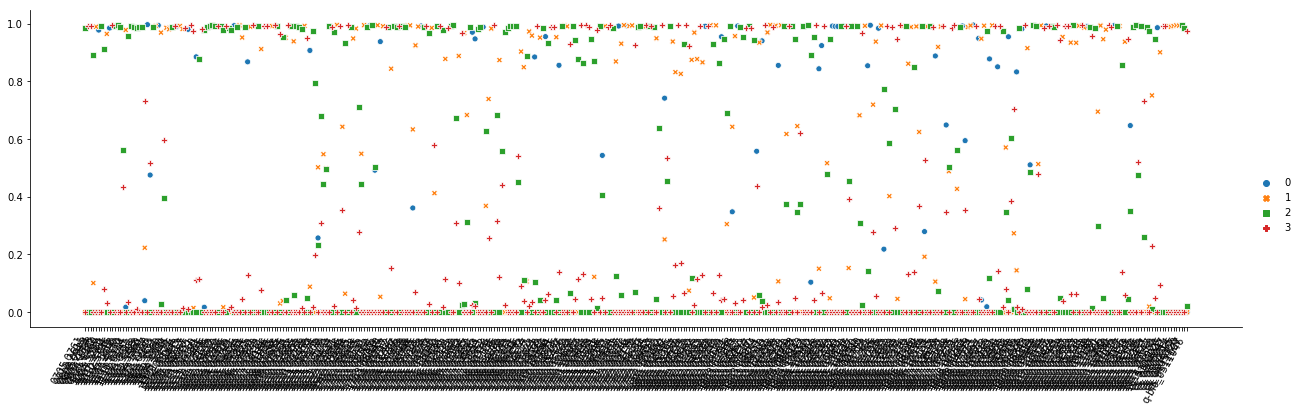

In [8]:
tbd = atm.topics_by_document(num_topics=4)
vis = sns.relplot(data=tbd, aspect=3.5)
vis.set_xticklabels(rotation=60, ha='right')
vis

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


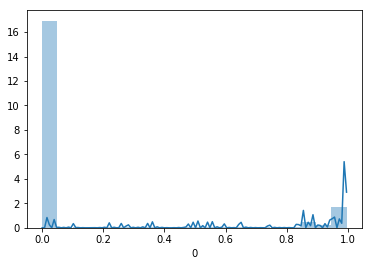

In [9]:
sns.distplot(tbd[0])

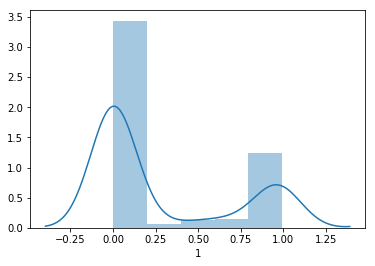

In [10]:
sns.distplot(tbd[1])

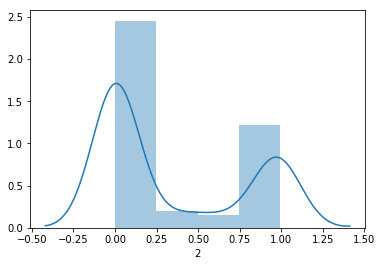

In [11]:
sns.distplot(tbd[2])

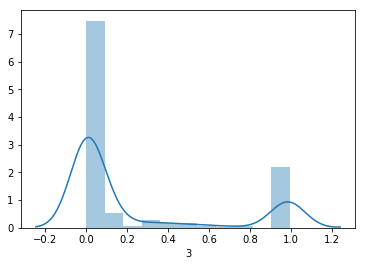

In [12]:
sns.distplot(tbd[3])

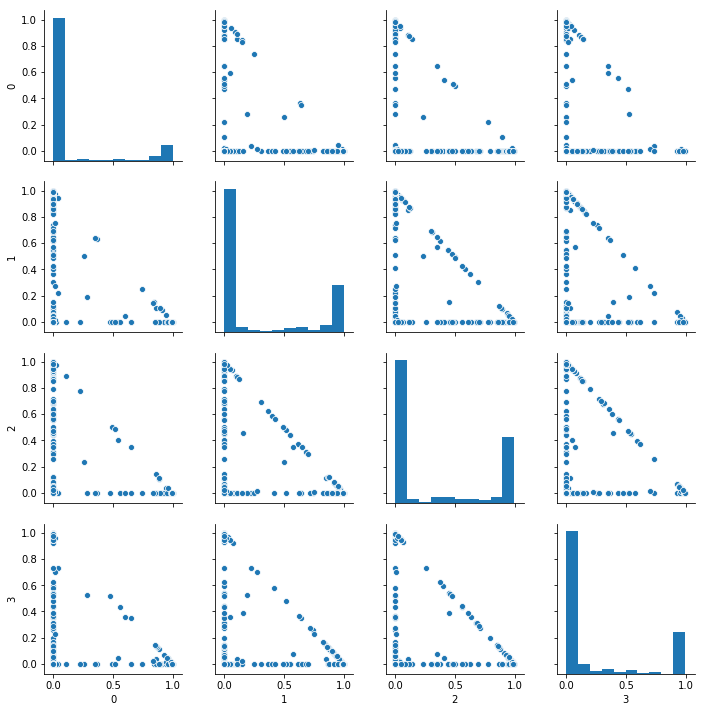

In [13]:
sns.pairplot(tbd)

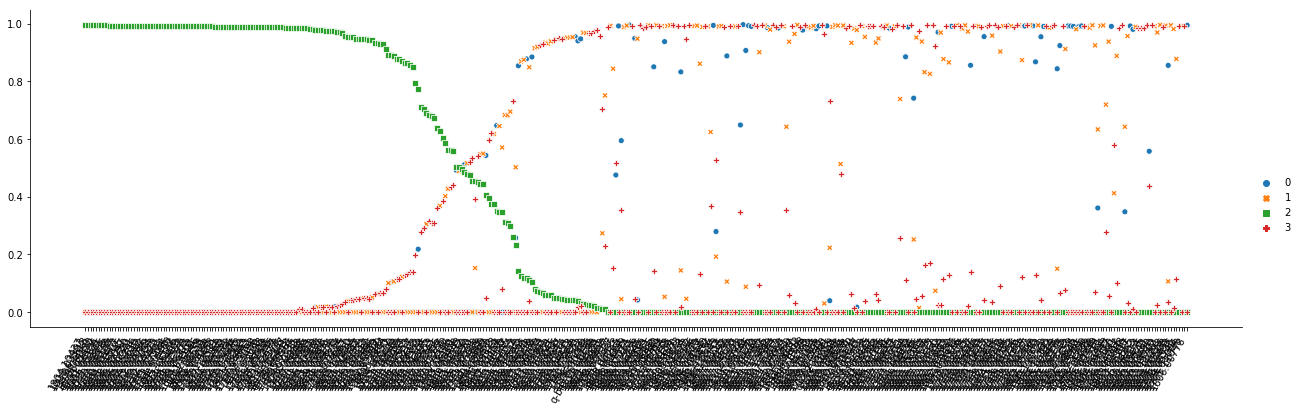

In [14]:
vis = sns.relplot(data=tbd.sort_values([2], ascending=False), aspect=3.5)
vis.set_xticklabels(rotation=60, ha='right')

# Dirty implementation of In Text Visualization

In [15]:
num_topics = 4
largest = 10
num_words = 100
topic = 0

top_tbd = {}
for i in tbd.keys():
    top_tbd[i] = list(tbd.nlargest(largest, i)[0].keys())

atm.get_topics_by_term(num_topics=num_topics, num_words=num_words)
tbt = atm.data['lda'][num_topics]['tbt']

top_tbt = {}
for i in tbt.keys():
    top_tbt[i] = list(tbt.nlargest(num_words, i)[0].keys())

def construct_text_viz(top_tbd, topic, mapper):
    results = '<table>'
    for doc_id in top_tbd[topic]:
        for item in atm.data['raw']:
            if item[0] == doc_id:
                rtext = item[1]
                ptext = atm.preprocess_text(rtext)
                stext = []
                for word in ptext:
                    if word in top_tbt[0]:
                        w = '<span style=\"background-color:'+str(matplotlib.colors.to_hex(mapper.to_rgba(tbt[0][word])))+';\"><b>'+word+'</b></span>'
                        stext.append(w)
                    else:
                        stext.append(word)

                stext = ' '.join(stext)
                results += '<tr><td>'+str(doc_id)+'</td><td>'+rtext+'</td><td>'+stext+'</td></tr>'
    results = results + '</table>'
    return results


results = '''<html><head>
<style>
html {font-family:Open Sans;}
h1   {color: black;}
table {border-spacing: 1.5rem;
border: 1px solid black;}
table {align:left;}
td    {text-aligh: left;
padding: 0.5rem;
vertical-align: top;}
.centered {
  width: 70%;
  margin: 0 auto;}
</style></head><body>'''
for topic in top_tbd.keys():
    lst = list(tbt.nlargest(num_words, i)[topic])
    minima = min(lst)
    maxima = max(lst)
    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.autumn_r) #Hot)
    tmp = construct_text_viz(top_tbd, topic, mapper)
    results += '<div class="centered"><h1>Topic '+str(topic)+'</h1>'+tmp+'</div>'
results += '</body></html>'

with open('textviztext.html', 'w') as outfile:
    outfile.write(results)


In [16]:
HTML(results)

# Potenzielle Verbesserungen

## Pre Analysis

## Filtern selterner und häufiger Worte

dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

See: https://www.kaggle.com/ykhorramz/lda-and-t-sne-interactive-visualization

# Weitere Analyse

## Topics in Text

See: https://www.kaggle.com/ykhorramz/lda-and-t-sne-interactive-visualization


# Check out

spacy library for language processing


TOM Library for topic modelling and browsing (??? Whats the browsing part???)
http://mediamining.univ-lyon2.fr/people/guille/tom.php
https://github.com/AdrienGuille/TOM


3d.js: 
Focus node explorer with d3.js
http://ramblings.mcpher.com/Home/excelquirks/gassites/d3nodefocus

## Network Visualization

NetworkX
https://www.udacity.com/wiki/creating-network-graphs-with-python


### Create Netword data out of model:
http://intelligentonlinetools.com/blog/2017/01/22/data-visualization-visualizing-an-lda-model-using-python/

- The work with models created with Mallet

Semantic Network
In LDA, topics are clusters of terms that co-occur in documents. We can interpret an LDA topic model as a network of terms linked by their participation in particular topics. In Tethne, we call this a topic-coupling network.

Requires tethne. But pip3 install fails!



## Plotting words and documents in 2d
Plotting words and documents in 2D with SVD
We can use SVD with 2 components (topics) to display words and documents in 2D. The process is really similar. Let’s start with displaying documents since it’s a bit more straightforward.
see: https://nlpforhackers.io/topic-modeling/


**No: stemming, lemmatizing, bigrams, trigrams**

```
d = preprocess_corpus(data, lemmatize_words=False, stem_words=False, bigrams=False, trigrams=False)
ldamodel, corpus, dictionary = lda(d[1])
vis_data = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis_data)
```

```
d = preprocess_corpus(data, lemmatize_words=False, stem_words=False, bigrams=False, trigrams=False)
ldamodel, corpus, dictionary = lda(d[1], num_topics=6)
vis_data = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis_data)
```

**Stemming: Yes, No: Lemmata, bigrams or trigrams**

```
d = preprocess_corpus(data, lemmatize_words=False, stem_words=True, bigrams=False, trigrams=False)
ldamodel, corpus, dictionary = lda(d[1], num_topics=10)
vis_data = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis_data)

d = preprocess_corpus(data, lemmatize_words=False, stem_words=True, bigrams=False, trigrams=False)
ldamodel, corpus, dictionary = lda(d[1], num_topics=4)
vis_data = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis_data)
```

**Lemmatize, NO: Stemming, bigrams, trigrams**
```
d = preprocess_corpus(data, lemmatize_words=True, stem_words=False, bigrams=False, trigrams=False)
ldamodel, corpus, dictionary = lda(d[1], num_topics=10)
vis_data = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis_data)

d = preprocess_corpus(data, lemmatize_words=True, stem_words=False, bigrams=False, trigrams=False)
ldamodel, corpus, dictionary = lda(d[1], num_topics=5)
vis_data = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis_data)
```

**Lemmatize, bigrams, trigrams. NO: Stemming**
```
d = preprocess_corpus(data, lemmatize_words=True, stem_words=False, bigrams=True, trigrams=True)
ldamodel, corpus, dictionary = lda(d[1], num_topics=10)
vis_data = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis_data)

d = preprocess_corpus(data, lemmatize_words=True, stem_words=False, bigrams=True, trigrams=True)
ldamodel, corpus, dictionary = lda(d[1], num_topics=4)
vis_data = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis_data)

d = preprocess_corpus(data, lemmatize_words=True, stem_words=False, bigrams=True, trigrams=True)
ldamodel, corpus, dictionary = lda(d[1], num_topics=4, tfidf=True)
vis_data = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis_data)
```